# Vision Tranformer Classifciation of Cifer-10 DataSet

1. Import Libraries

In [3]:
!pip install numpy
!pip install tensorflow==2.8.0
!pip install keras==2.8.0
!pip install tensorflow_addons==0.20.0 #(0.17.0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 42.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: goo

2. Import / Download dataset

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
num_classes=10
input_shape=(32,32,3)

(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

170508288/170498071 [==============================] - 3s 0us/step


3. Print the dimensions (shapes) of training and testing data arrays in a machine learning context.

In [2]:
print(f'x_train shape:{x_train.shape} - y_train_shape:{y_train.shape}')
print(f'x_test shape:{x_test.shape} - y_test_shape:{y_test.shape}')

x_train shape:(50000, 32, 32, 3) - y_train_shape:(50000, 1)
x_test shape:(10000, 32, 32, 3) - y_test_shape:(10000, 1)


4. Training and testing data sets to their first 500 and 100 samples, respectively.

In [3]:
x_train = x_train[:500]
y_train = y_train[:500]
x_test = x_test[:100]
y_test = y_test[:100]

5. Define hyperparameters and configurations variables for a neural network-based model

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72
patch_size = 6
num_patches = (image_size//patch_size)**2
projections_dim = 64
num_heads = 4
transform_units = [projections_dim*2,projections_dim]
transform_layers = 8
mlp_head_units = [2048,1024]

6. Defining a Keras data augmentation pipeline

In [5]:
data_augmentation=keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2,width_factor=0.2)
    ],
    name='data_augmentation'
)
data_augmentation.layers[0].adapt(x_train)

7. Construction a multi-layer perceptron (MLP)

In [6]:
def mlp(x,hidden_units,dropout_rate):
    for units in hidden_units:
        x=layers.Dense(units, activation=tf.nn.gelu)(x)
        x=layers.Dropout(dropout_rate)(x)
    return x

8. Extraction of image patches from input images, and returning them as a reshaped tensor.

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

9. Extraction and Visualization of patches from a randomly selected image

image size:72X72
patch size:6X6
patches for image:144
elements for patch:108


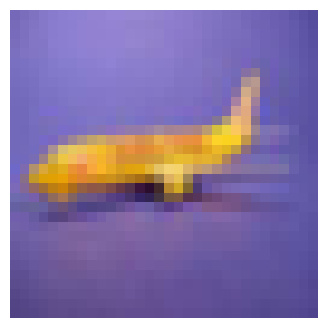

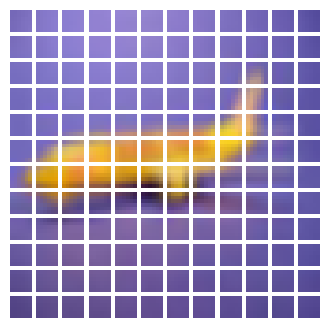

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f'image size:{image_size}X{image_size}')
print(f'patch size:{patch_size}X{patch_size}')
print(f'patches for image:{tf.shape(patches)[1]}')
print(f'elements for patch:{tf.shape(patches)[-1]}')
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

10. Encoding patches extracted from images.

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches,projections_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches=num_patches
        self.projections_dim=layers.Dense(units=projections_dim)
        self.position_embedding=layers.Embedding(input_dim=num_patches,
                                                 output_dim=projections_dim)

    def call(self,patch):
        positions = tf.range(start=0,limit=self.num_patches,delta=1)
        encoded=self.projections_dim(patch)+self.position_embedding(positions)
        return encoded

11. Construction of Vision Transformer(ViT) model for Image classification

In [10]:
from numpy.random.mtrand import logistic

def create_vit_classifier():
    inputs=layers.Input(shape=input_shape)
    # Augment dats
    augmented=data_augmentation(inputs)
    # Create patches
    patches=Patches(patch_size)(augmented)
    # Encode patches
    encoded_patches=PatchEncoder(num_patches,projections_dim)(patches)

    # Create multiple Layers of the Transformer block
    for _ in range(transform_layers):
        # layer Normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention Layer
        attention_output=layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projections_dim ,dropout=0.1
        )(x1,x1)
        # Skip connection 1
        x2=layers.Add()([attention_output,encoded_patches])
        # Layer Normalization 2
        x3=layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3=mlp(x3,hidden_units=transform_units,dropout_rate=0.1)
        # Skip connection 2
        encoded_patches=layers.Add()([x2,x3])

    # Create a [batch_size, projection_dim] tensor
    representation=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation=layers.Flatten()(representation)
    representation=layers.Dropout(0.5)(representation)
    # add MLP
    features=mlp(representation,hidden_units=mlp_head_units,dropout_rate=0.5)
    # Classify outputs
    logits=layers.Dense(num_classes)(features)
    # Create the keras Model
    model=keras.Model(inputs=inputs,outputs=logits)
    return model

12. Function to train a Machine Learning Model

In [11]:
def run_experiment(model):
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate,weight_decay=weight_decay)

    model.compile(optimizer=optimizer,
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
                            keras.metrics.SparseTopKCategoricalAccuracy(5,name='top_5_accuracy'),],)
    checkpoint_filepath="./tmp.checkpoint"
    checkpoint_callback=keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        ave_weights_only=True)

    history = model.fit(x = x_train,
                        y = y_train,
                        batch_size = batch_size,
                        epochs=num_epochs,
                        validation_split=0.1,
                        callbacks=[checkpoint_callback], )

    model.load_weights(checkpoint_filepath)
    _,accuracy,top_5_accuracy=model.evaluate(x_test, y_test)
    print(f'Test accuracy:{round(accuracy*100,2)}%')
    print(f'Test Top 5 accuracy:{round(top_5_accuracy*100,2)}%')

13. Creation of a Vision Transformer (ViT) classifier model

In [13]:
vit_classifier=create_vit_classifier()
history=run_experiment(vit_classifier)

Epoch 1/40
2/2 [==============================] - ETA: 0s - loss: 6.0090 - accuracy: 0.1311 - top_5_accuracy: 0.5333 

2/2 [==============================] - 62s 29s/step - loss: 6.0090 - accuracy: 0.1311 - top_5_accuracy: 0.5333 - val_loss: 5.3477 - val_accuracy: 0.2000 - val_top_5_accuracy: 0.6000
Epoch 2/40
2/2 [==============================] - 38s 14s/step - loss: 6.0111 - accuracy: 0.1889 - top_5_accuracy: 0.5933 - val_loss: 3.1185 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.6600
Epoch 3/40
2/2 [==============================] - 33s 13s/step - loss: 3.9582 - accuracy: 0.2089 - top_5_accuracy: 0.6622 - val_loss: 2.8073 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.6800
Epoch 4/40
2/2 [==============================] - 30s 13s/step - loss: 3.0604 - accuracy: 0.2222 - top_5_accuracy: 0.7067 - val_loss: 2.2200 - val_accuracy: 0.1400 - val_top_5_accuracy: 0.6800
Epoch 5/40
2/2 [==============================] - ETA: 0s - loss: 2.6840 - accuracy: 0.2422 - top_5_accuracy: 0.7133 

2/2 [==============================] - 52s 35s/step - loss: 2.6840 - accuracy: 0.2422 - top_5_accuracy: 0.7133 - val_loss: 2.0833 - val_accuracy: 0.3800 - val_top_5_accuracy: 0.7400
Epoch 6/40
2/2 [==============================] - 31s 14s/step - loss: 2.4898 - accuracy: 0.2489 - top_5_accuracy: 0.7400 - val_loss: 2.1002 - val_accuracy: 0.2600 - val_top_5_accuracy: 0.6800
Epoch 7/40
2/2 [==============================] - 33s 14s/step - loss: 2.3326 - accuracy: 0.2644 - top_5_accuracy: 0.7511 - val_loss: 2.0865 - val_accuracy: 0.2000 - val_top_5_accuracy: 0.6600
Epoch 8/40
2/2 [==============================] - 31s 14s/step - loss: 2.1894 - accuracy: 0.2956 - top_5_accuracy: 0.7933 - val_loss: 1.9759 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.7800
Epoch 9/40
2/2 [==============================] - 31s 14s/step - loss: 1.9794 - accuracy: 0.3333 - top_5_accuracy: 0.8244 - val_loss: 1.9463 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.7600
Epoch 10/40
2/2 [=============================

14. Categories or labels for a classification task

In [12]:
class_names=[
    'airplane',
    'truck',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
]

15. Predictions for the class labels of the input images

In [14]:
def img_perdict(images,model):
    if len(images.shape) == 3:
        out=model.predict(images.reshape(-1,*images.shape))
    else:
        out=model.predict(images)
    prediction=np.argmax(out, axis=1)
    img_prediction=[class_names[i] for i in prediction]
    return img_prediction

16. Displaying an image from the test data at an index

['truck']


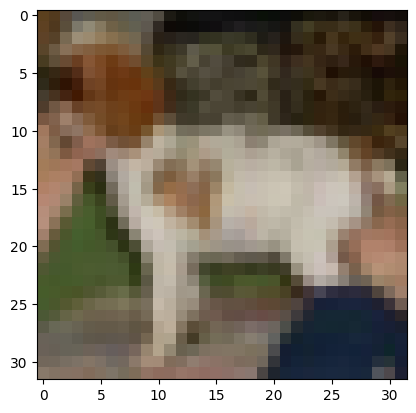

In [15]:
index = 12
plt.imshow(x_test[index])
prediction = img_perdict(x_test[index], vit_classifier)
print(prediction)

['airplane']


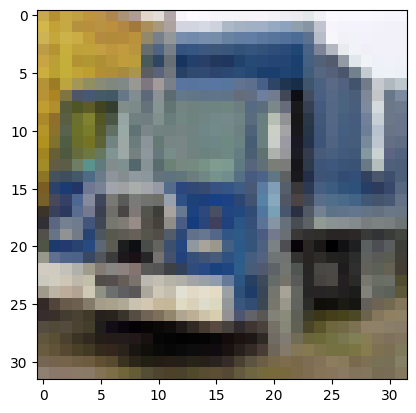

In [16]:
index = 14
plt.imshow(x_test[index])
prediction = img_perdict(x_test[index], vit_classifier)
print(prediction)